In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os

train_df = pd.read_parquet("UNSW-NB15/UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet("UNSW-NB15/UNSW_NB15_testing-set.parquet")


print("--- Initial Data Shapes ---")
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

print("\nTraining Set Sample")
print(train_df.head())

print("\nColumns")
print(train_df.columns.tolist())

--- Initial Data Shapes ---
Training set shape: (175341, 36)
Testing set shape: (82332, 36)

Training Set Sample
        dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087486   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473373   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373825   

          sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  14158.942383  ...            0                  0                 1   
1   8395.112305  ...            0                  0                 1   
2   1572.271851  ...            0                  0                 1   
3   2740.178955  ...            0                  0                 1   
4   8561.499023  ...            0                  0        

In [5]:
# Store initial row counts
train_initial_rows = len(train_df)
test_initial_rows = len(test_df)

# Drop duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

print(f"Removed {train_initial_rows - len(train_df)} duplicates from the training set.")
print(f"Removed {test_initial_rows - len(test_df)} duplicates from the testing set.")


print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# Check class distribution after cleaning
print("Training set labels:\n", train_df['label'].value_counts(normalize=True))
print("\nTesting set labels:\n", test_df['label'].value_counts(normalize=True))

Removed 78519 duplicates from the training set.
Removed 32361 duplicates from the testing set.
Training set shape: (96822, 36)
Testing set shape: (49971, 36)
Training set labels:
 label
0    0.504989
1    0.495011
Name: proportion, dtype: float64

Testing set labels:
 label
0    0.632567
1    0.367433
Name: proportion, dtype: float64


In [6]:
def feature_engineer(df):
    df_new = df.copy()
    
    # Packet and byte rates
    df_new['packet_rate'] = df_new['spkts'] / (df_new['dur'] + 1e-6)
    df_new['byte_rate'] = df_new['sbytes'] / (df_new['dur'] + 1e-6)
    
    # Ratios
    df_new['response_size_ratio'] = df_new['sbytes'] / (df_new['dbytes'] + 1e-6)
    
    # Aggregates
    df_new['total_packets'] = df_new['spkts'] + df_new['dpkts']

    # Replace any potential infinite values that may arise from division
    df_new.replace([np.inf, -np.inf], 0, inplace=True)

    return df_new

print("--- Applying Feature Engineering ---")
train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

print("New features created: 'packet_rate', 'byte_rate', 'response_size_ratio', 'total_packets'")
print("Training set shape after feature engineering:", train_df.shape)
print("Testing set shape after feature engineering:", test_df.shape)

--- Applying Feature Engineering ---
New features created: 'packet_rate', 'byte_rate', 'response_size_ratio', 'total_packets'
Training set shape after feature engineering: (96822, 40)
Testing set shape after feature engineering: (49971, 40)


In [7]:
# Preprocessing Pipeline

# Separate features (X) from the target labels (y) and metadata (attack_cat)
X_train = train_df.drop(['label', 'attack_cat'], axis=1).reset_index(drop=True)
y_train = train_df['label'].reset_index(drop=True)

X_test = test_df.drop(['label', 'attack_cat'], axis=1).reset_index(drop=True)
y_test = test_df['label'].reset_index(drop=True)


# Identify column types from the training set
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"Identified {len(numerical_cols)} numerical features.")
print(f"Identified {len(categorical_cols)} categorical features: {categorical_cols}")

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False makes it easier to work with
])

# Create the master preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data and transform both sets
print("\n--- Fitting Preprocessor on Training Data and Transforming ---")
X_train_processed_np = preprocessor.fit_transform(X_train)
X_test_processed_np = preprocessor.transform(X_test)

# Get feature names after transformation for creating a DataFrame
processed_num_features = numerical_cols
try:
    # scikit-learn >= 0.22
    processed_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
except AttributeError:
    # Older scikit-learn versions
    processed_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_cols).tolist()

all_feature_names = processed_num_features + processed_cat_features

# Convert the processed numpy array back to a dense DataFrame
X_train_processed = pd.DataFrame(X_train_processed_np, columns=all_feature_names)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=all_feature_names)


print("Preprocessing complete.")
print("Processed training data shape:", X_train_processed.shape)
print("Processed testing data shape:", X_test_processed.shape)
print("\n--- Sample of Processed Training Data ---")
print(X_train_processed.head())

Identified 35 numerical features.
Identified 3 categorical features: ['proto', 'service', 'state']

--- Fitting Preprocessor on Training Data and Transforming ---
Preprocessing complete.
Processed training data shape: (96822, 190)
Processed testing data shape: (49971, 190)

--- Sample of Processed Training Data ---
        dur     spkts     dpkts    sbytes    dbytes      rate         sload  \
0  0.002025  0.000520  0.000364  0.000018  0.000012  0.000074  2.364553e-06   
1  0.010832  0.001352  0.003463  0.000054  0.002867  0.000078  1.401989e-06   
2  0.027052  0.000728  0.001458  0.000026  0.000900  0.000014  2.625704e-07   
3  0.028027  0.001144  0.001093  0.000046  0.000053  0.000014  4.576117e-07   
4  0.007491  0.000936  0.000547  0.000039  0.000018  0.000033  1.429776e-06   

      dload     sloss     dloss  ...  service_ssl  state_CON  state_ECO  \
0  0.000379  0.000000  0.000000  ...          0.0        0.0        0.0   
1  0.022458  0.000416  0.003100  ...          0.0        0

In [8]:
# Create a directory to store the processed data
os.makedirs('processed_data', exist_ok=True)

# GANomaly trains only on normal data
normal_indices_train = y_train[y_train == 0].index
X_train_normal_ganomaly = X_train_processed.iloc[normal_indices_train]

# Save GANomaly datasets
X_train_normal_ganomaly.to_parquet('processed_data/ganomaly_X_train_normal.parquet', index=False)
X_test_processed.to_parquet('processed_data/ganomaly_X_test.parquet', index=False)
y_test.to_frame().to_parquet('processed_data/ganomaly_y_test.parquet', index=False)

print("--- GANomaly Data ---")
print(f"Shape of normal training data for GANomaly: {X_train_normal_ganomaly.shape}")
print(f"Shape of testing data for GANomaly: {X_test_processed.shape}")

# Prepare Data for CBIGAN
# CBIGAN is trained on both normal and attack data.


X_train_processed.to_parquet('processed_data/cbigan_X_train.parquet', index=False)
y_train.to_frame().to_parquet('processed_data/cbigan_y_train.parquet', index=False)
X_test_processed.to_parquet('processed_data/cbigan_X_test.parquet', index=False)
y_test.to_frame().to_parquet('processed_data/cbigan_y_test.parquet', index=False)

print("\n--- CBIGAN Data ---")
print(f"Shape of training data for CBIGAN: {X_train_processed.shape}")
print(f"Shape of testing data for CBIGAN: {X_test_processed.shape}")

print("\nAll processed datasets have been saved in the 'processed_data/' directory.")

--- GANomaly Data ---
Shape of normal training data for GANomaly: (48894, 190)
Shape of testing data for GANomaly: (49971, 190)

--- CBIGAN Data ---
Shape of training data for CBIGAN: (96822, 190)
Shape of testing data for CBIGAN: (49971, 190)

All processed datasets have been saved in the 'processed_data/' directory.


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm # For a nice progress bar

# --- Configuration & Hyperparameters ---
LATENT_DIM = 128
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 1e-4
W_ADV = 1    # Weight for Adversarial Loss
W_CON = 50   # Weight for Contextual Loss
W_ENC = 1    # Weight for Encoder Loss

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load the Datasets ---
print("--- Loading Preprocessed Data for GANomaly ---")

X_train_normal = pd.read_parquet('processed_data/ganomaly_X_train_normal.parquet')
X_test = pd.read_parquet('processed_data/ganomaly_X_test.parquet')
y_test = pd.read_parquet('processed_data/ganomaly_y_test.parquet')['label']


INPUT_DIM = X_train_normal.shape[1]

# PyTorch Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32) if labels is not None else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx], -1 # Return a dummy label for training data

# Create datasets
train_dataset = CustomDataset(X_train_normal)
test_dataset = CustomDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nInput Dimension: {INPUT_DIM}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Training data shape: {X_train_normal.shape}")
print(f"Testing data shape: {X_test.shape}")

Using device: cuda
--- Loading Preprocessed Data for GANomaly ---

Input Dimension: 190
Latent Dimension: 128
Training data shape: (48894, 190)
Testing data shape: (49971, 190)


In [10]:
class Generator(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        self.latent_layer = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # To output values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        z = self.latent_layer(encoded)
        reconstruction = self.decoder(z)
        return reconstruction, z

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        self.feature_layer = nn.Linear(256, 128)
        self.final_layer = nn.Linear(128, 1)

    def forward(self, x):
        features = self.model(x)
        feature_vector = self.feature_layer(features)
        prediction = torch.sigmoid(self.final_layer(feature_vector))
        return prediction.squeeze(), feature_vector

# --- Instantiate the models and move to device ---
generator = Generator(INPUT_DIM, LATENT_DIM).to(device)
discriminator = Discriminator(INPUT_DIM).to(device)

print("--- Generator Architecture ---")
print(generator)
print("\n--- Discriminator Architecture ---")
print(discriminator)

--- Generator Architecture ---
Generator(
  (encoder): Sequential(
    (0): Linear(in_features=190, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (latent_layer): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=190, bias=True)
    (6): Sigmoid()
  )
)

--- Discriminator Architecture ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=190, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256,

In [ ]:
# Loss Functions
loss_adv = nn.MSELoss().to(device)  # Adversarial loss (feature matching)
loss_con = nn.L1Loss().to(device)   # Contextual loss (reconstruction)
loss_enc = nn.MSELoss().to(device)  # Encoder loss
loss_d = nn.BCELoss().to(device)    # Discriminator's real/fake loss

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

print("Optimizers and Loss functions have been set up.")

Optimizers and Loss functions have been set up.


Epoch [50/50]: 100%|██████████| 191/191 [00:03<00:00, 51.38it/s, d_loss=0.497, g_loss=0.474]



--- Model Training Complete ---


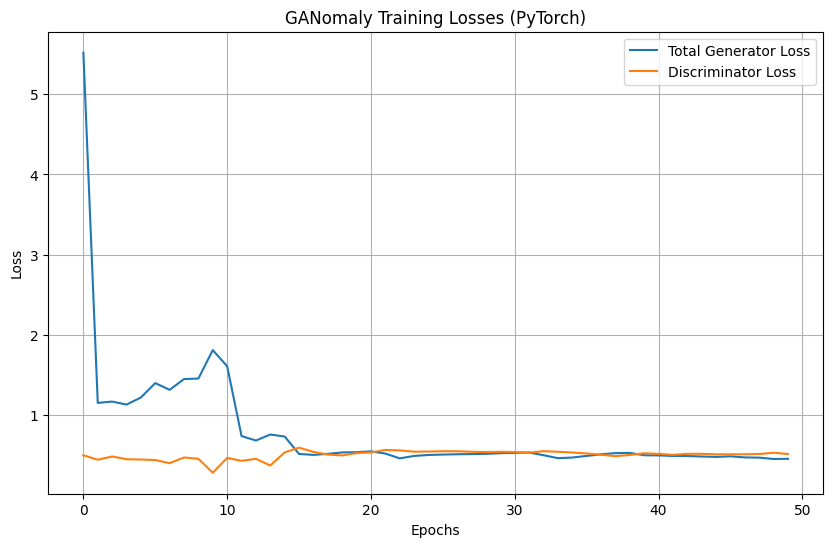

In [12]:
# GANomaly Model Training

# Lists to store loss history
g_losses = []
d_losses = []

generator.train()
discriminator.train()

for epoch in range(EPOCHS):
    # Using tqdm for a progress bar
    loop = tqdm(train_loader, leave=True)
    total_g_loss = 0.0
    total_d_loss = 0.0
    
    for i, (real_x, _) in enumerate(loop):
        real_x = real_x.to(device)
        
        # Create labels for discriminator training
        real_labels = torch.ones(real_x.size(0)).to(device)
        fake_labels = torch.zeros(real_x.size(0)).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_d.zero_grad()
        
        # On real data
        d_real_pred, _ = discriminator(real_x)
        d_real_loss = loss_d(d_real_pred, real_labels)
        
        # On fake data
        fake_x, _ = generator(real_x)
        d_fake_pred, _ = discriminator(fake_x.detach()) # Detach to avoid backprop into generator
        d_fake_loss = loss_d(d_fake_pred, fake_labels)
        
        # Total discriminator loss
        d_loss_total = (d_real_loss + d_fake_loss) / 2
        d_loss_total.backward()
        optimizer_d.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_g.zero_grad()
        
        # Get discriminator features for real and fake data
        _, real_features = discriminator(real_x)
        fake_x_for_g, z_fake = generator(real_x)
        _, fake_features = discriminator(fake_x_for_g)
        
        # Calculate generator losses
        g_loss_adv = loss_adv(fake_features, real_features)
        g_loss_con = loss_con(fake_x_for_g, real_x)
        
        # Re-encode the generated image to get latent vector for enc loss
        _, z_real = generator(real_x) # We need the real latent vector
        g_loss_enc = loss_enc(z_fake, z_real)
        
        # Total generator loss
        g_loss_total = W_ADV * g_loss_adv + W_CON * g_loss_con + W_ENC * g_loss_enc
        g_loss_total.backward()
        optimizer_g.step()

        # --- Logging ---
        total_g_loss += g_loss_total.item()
        total_d_loss += d_loss_total.item()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(g_loss=g_loss_total.item(), d_loss=d_loss_total.item())
        
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

print("\n--- Model Training Complete ---")

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label='Total Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('GANomaly Training Losses (PyTorch)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("evaluating Model and Calculating Anomaly Scores")

# Set models to evaluation mode
generator.eval()
discriminator.eval()

reconstruction_errors = []
with torch.no_grad():
    for i, (batch_x, _) in enumerate(test_loader):
        batch_x = batch_x.to(device)
        
        # Get reconstruction from generator
        reconstructions, _ = generator(batch_x)
        
        # Calculate L1 loss (MAE) for each sample in the batch
        errors = torch.mean(torch.abs(batch_x - reconstructions), dim=1)
        
        # Move errors to CPU and append to list
        reconstruction_errors.extend(errors.cpu().numpy())

anomaly_scores = np.array(reconstruction_errors)

# --- Find Optimal Threshold using ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Area under ROC curve (AUC-ROC): {roc_auc:.4f}")
print(f"Optimal threshold found via Youden's J statistic: {optimal_threshold:.4f}")

# --- Evaluate using the optimal threshold ---
y_pred = (anomaly_scores >= optimal_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Attack (1)']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Plot ROC and PR Curves ---
precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()